# 03 Haabersti hõberemmelgas konflikt

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import csv
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
from wordcloud import WordCloud
from estnltk import Text
import re

In [10]:
konflikt = 'Haabersti hõberemmelgas'
data = pd.read_excel('Code_KÕIK TEKSTID_Haabersti_hoberemmelgas.xlsx', engine='openpyxl')

In [11]:
data.shape

(329, 9)

## 1. Andmete töötlemine

In [12]:
date = data['date'].to_list()

In [13]:
# Artikli kuupäeva teisendamine

kuupäevad = []
aastad = []
kuud = []
päevad = []
aasta_kuud =[]
for d in date:
    match = re.search(r'\d{4}\-\d{2}\-\d{2}', d)
    if match:
        kuupäev = match[0][0:10]
        aasta = match[0][0:4]
        kuu = match[0][5:7]
        päev = match[0][8:10]
        aasta_kuu = match[0][0:7]
    kuupäevad.append(kuupäev) 
    aastad.append(aasta)
    kuud.append(kuu)
    päevad.append(päev)
    aasta_kuud.append(aasta_kuu)

In [14]:
# Tunnuste lisamine andmestikku

data['kuupäev']=kuupäevad
data['aasta']=aastad
data['kuu']=kuud
data['päev']=päevad
data['aasta_kuu']=aasta_kuud

In [15]:
kuupäevad

['2021-04-13',
 '2021-04-10',
 '2020-11-21',
 '2019-11-24',
 '2019-07-12',
 '2018-11-11',
 '2018-09-27',
 '2018-06-27',
 '2018-06-26',
 '2018-05-16',
 '2018-04-06',
 '2017-12-28',
 '2017-12-27',
 '2017-08-15',
 '2017-08-01',
 '2017-07-20',
 '2017-07-16',
 '2017-07-14',
 '2017-07-04',
 '2017-07-04',
 '2017-07-04',
 '2017-07-02',
 '2017-06-29',
 '2017-06-29',
 '2017-06-29',
 '2017-06-29',
 '2018-10-16',
 '2017-06-28',
 '2017-06-28',
 '2017-06-28',
 '2017-06-28',
 '2018-06-15',
 '2017-06-27',
 '2018-01-14',
 '2017-06-27',
 '2017-06-27',
 '2017-06-27',
 '2017-07-26',
 '2017-06-27',
 '2017-06-27',
 '2017-06-27',
 '2017-07-01',
 '2017-06-27',
 '2017-06-27',
 '2017-06-26',
 '2017-06-26',
 '2017-06-28',
 '2017-06-25',
 '2017-06-24',
 '2017-06-28',
 '2017-06-28',
 '2017-06-22',
 '2017-06-22',
 '2017-06-21',
 '2017-06-21',
 '2017-06-20',
 '2017-06-27',
 '2017-06-20',
 '2017-06-20',
 '2017-06-20',
 '2017-06-27',
 '2017-06-19',
 '2017-06-19',
 '2017-06-18',
 '2017-06-18',
 '2017-06-18',
 '2017-06-

In [16]:
len(kuupäevad)

329

In [17]:
# Mittevajalike tunnuste eemaldamine

del data['date']

In [18]:
data.shape

(329, 13)

## 2. Väljaanded

In [19]:
jaotus1 = data['subject'].value_counts(ascending = False)
tabel1 = pd.DataFrame({'Väljaande nimi':jaotus1.index, 'Artikleid':jaotus1.values})
tabel1['Osakaal, %'] = round((tabel1['Artikleid'] / 
                      tabel1['Artikleid'].sum() )* 100, 1)
tabel1_1 = tabel1.style.set_caption(konflikt + ": vaadeldud artikleid väljaannete kaupa")
tabel1.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel1_Väljaanded.xlsx") 

INFO:utils.py:159: NumExpr defaulting to 8 threads.


In [20]:
tabel1_1

,Väljaande nimi,Artikleid,"Osakaal, %"
0,Postimees,88,26.700000
1,Õhtuleht,50,15.200000
2,Delfi,43,13.100000
3,ERR,35,10.600000
4,Eesti Päevaleht,19,5.800000
5,Pealinn,15,4.600000
6,Maaleht,13,4.000000
7,Eesti Ekspress,13,4.000000
8,Uued Uudised,9,2.700000
9,Meie Maa,6,1.800000


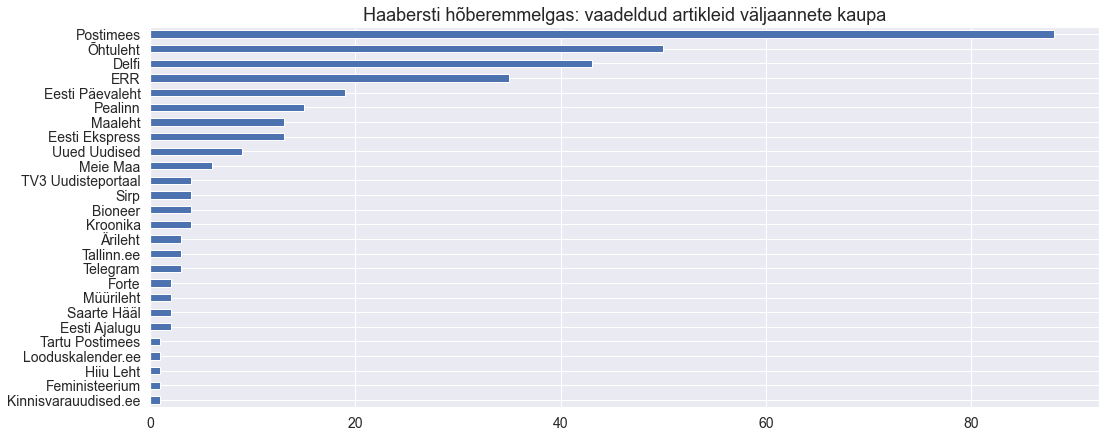

In [71]:
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(17,7))
plt.title(konflikt + ": vaadeldud artikleid väljaannete kaupa", size=18)
data['subject'].value_counts(ascending = True).plot(ax=ax, kind='barh', fontsize=14)
plt.savefig("tulemused_" + konflikt +"/" + konflikt + " joonis1_Väljaanded.png")
plt.show()

## 3. Sõnapilvede loomine

In [22]:
#https://et.wikipedia.org/wiki/Sides%C3%B5na
#https://www.taskutark.ee/m/asesonad/
#sidesõnad
stopsõnad = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni']
#sidesõnad ja asesõnad
stopsõnad_uus = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni', 'siis', 'ka', 'nii', 'kas',
             'mina', 'ma', 'meie', 'me', 'sina', 'sa', 'teie', 'te', 'tema', 'ta', 'nemad', 'nad',
             'enese', 'enda', 'iseenese', 'iseenda', 'oma', 'üksteise', 'teineteise',
             'see', 'too', 'sama', 'seesama', 'toosama', 'teine', 'muu',
             'niisugune', 'samasugune', 'niisamasugune', 'selline', 'seesugune', 'säärane','säherdune', 
             'taoline', 'selletaoline', 'kes', 'mis', 'kumb', 'missugune', 'milline', 'misuke', 'mitu', 'mitmes', 'mitmendik',
             'ise', 'oma', 'iga', 'igaüks', 'igamees', 'kõik', 'mõlemad', 'kumbki', 'emb-kumb', 'kogu', 'terve',
             'keegi', 'miski', 'mingi', 'mingisugune', 'miskisugune', 'ükski', 'mitu', 'mitmes', 'mitu-setu', 'mitmes-setmes',
             'mõni', 'mõningane', 'paljud', 'üks', 'teine', 'oma', 'enese', 'enda', 'omaenese', 'omaenda', 'iseoma', 
             'iseenese', 'iseenda', 'emb', 'mõlema', 'palju']

## 3.1 Nimi- ja omadussõnad

### 3.1.1 Nimi- ja omadussõnad artiklite pealkirjades

EstNLTK vahenditega vaadeldakse uudistes esinevate sõnade lemmasid ja sõnade liike. Edaspidiseks vaatluseks eraldatakse nimisõnad (sõnaliik S) ja  omadussõnad (sõnaliigid A - algvõrre, C - keskvõrre, U - ülivõrre).

In [23]:
# Nimisõnade ja omadussõnade kasutamine

nimi_omadus_sonad = []
for i in tqdm(range (0, len(data))):
    rida = data.iloc[i]
    tekst = Text(rida[1]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'S' or sona[0][1] == 'A' or sona[0][1] == 'C' or sona[0][1] == 'U':
            nimi_omadus_sonad.append(sona[0][0])

nimi_omadus_words = ' '.join(map(str, nimi_omadus_sonad))

100%|███████████████████████████████████████████████████████████████████████████████| 329/329 [00:02<00:00, 161.25it/s]


Haabersti hõberemmelgas: pealkirjades nimisõnu ja omadussõnu sõnapilves:  1249


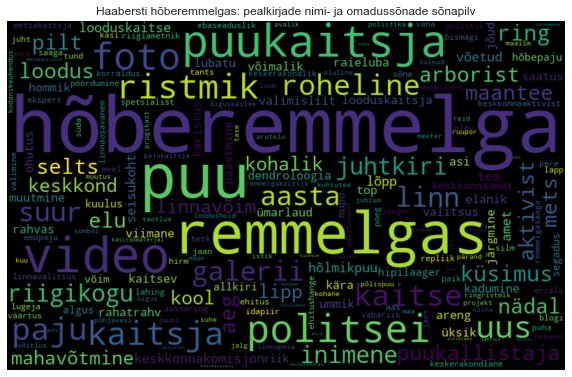

In [24]:
wordcloud_nimi_omadus = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(nimi_omadus_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_nimi_omadus, interpolation='bilinear')
plt.title(konflikt + ": pealkirjade nimi- ja omadussõnade sõnapilv")
plt.axis("off")
plt.savefig("tulemused_" + konflikt +"/" + konflikt + ' joonis2_Pealkirjad_nimi_omadus_sonapilv.png')
print(konflikt + ": pealkirjades nimisõnu ja omadussõnu sõnapilves: ", len(nimi_omadus_sonad))

### 3.1.2 Nimi- ja omadussõnade esinemissagedus artiklite pealkirjades

In [25]:
jaotus2 =pd.DataFrame(nimi_omadus_sonad, columns=['sõna'])
tabel2 = jaotus2.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:20]
tabel2['osakaal %']= (tabel2['esinemissagedus']/len(nimi_omadus_sonad)*100)
tabel2_1 = tabel2.style.set_caption(konflikt + ": pealkirjade nimi- ja omadussõnade TOP 20")
tabel2.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel2_Pealkirjad_nimi_omadus_TOP_20.xlsx") 

In [26]:
tabel2_1

,sõna,esinemissagedus,osakaal %
117,hõberemmelgas,74,5.924740
408,puu,43,3.442754
455,remmelgas,38,3.042434
604,video,27,2.161729
411,puukaitsja,22,1.761409
388,politsei,16,1.281025
90,foto,15,1.200961
471,ristmik,13,1.040833
155,kaitsja,12,0.960769
366,paju,11,0.880705


### 3.1.3 Nimi- ja omadussõnade kasutamine artiklite tekstides

In [27]:
# Nimisõnade ja omadussõnade kasutamine

nimi_omadus_sonad1 = []
for i in tqdm(range (0, len(data))):
    rida = data.iloc[i]
    tekst = Text(rida[2]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'S' or sona[0][1] == 'A' or sona[0][1] == 'C' or sona[0][1] == 'U':
            nimi_omadus_sonad1.append(sona[0][0])

nimi_omadus_words1 = ' '.join(map(str, nimi_omadus_sonad1))

100%|████████████████████████████████████████████████████████████████████████████████| 329/329 [01:26<00:00,  3.80it/s]


Haabersti hõberemmelgas: tekstides nimisõnu ja omadussõnu sõnapilves  58110


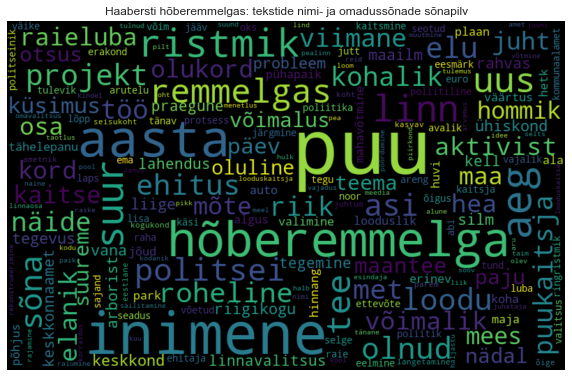

In [28]:
wordcloud_nimi_omadus1 = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(nimi_omadus_words1)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_nimi_omadus1, interpolation='bilinear')
plt.title(konflikt + ": tekstide nimi- ja omadussõnade sõnapilv")
plt.axis("off")
plt.savefig("tulemused_" + konflikt +"/" + konflikt + ' joonis3_Tekstid_nimi_omadus_sonapilv.png')
print(konflikt + ": tekstides nimisõnu ja omadussõnu sõnapilves ", len(nimi_omadus_sonad1))

### 3.1.4 Nimi- ja omadussõnade esinemissagedus artiklite tekstides

In [29]:
jaotus3 =pd.DataFrame(nimi_omadus_sonad1, columns=['sõna'])
tabel3 = jaotus3.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:20]
tabel3['osakaal %']= (tabel3['esinemissagedus']/len(nimi_omadus_sonad1)*100)
tabel3_1 = tabel3.style.set_caption(konflikt + ": tekstide nimi- ja omadussõnade TOP 20")
tabel3.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel3_Tekstid_nimi_omadus_TOP_20.xlsx") 

In [30]:
tabel3_1

,sõna,esinemissagedus,osakaal %
7094,puu,1681,2.892790
2149,inimene,867,1.491998
76,aasta,651,1.120289
1979,hõberemmelgas,581,0.999828
129,aeg,414,0.712442
7811,ristmik,358,0.616073
8554,suur,350,0.602306
4493,linn,329,0.566168
10002,uus,301,0.517983
7697,remmelgas,278,0.478403


## 3.2 Verbid

### 3.2.1 Verbid artiklite pealkirjades

100%|███████████████████████████████████████████████████████████████████████████████| 329/329 [00:01<00:00, 178.47it/s]


Haabersti hõberemmelgas: verbe sõnapilves  473


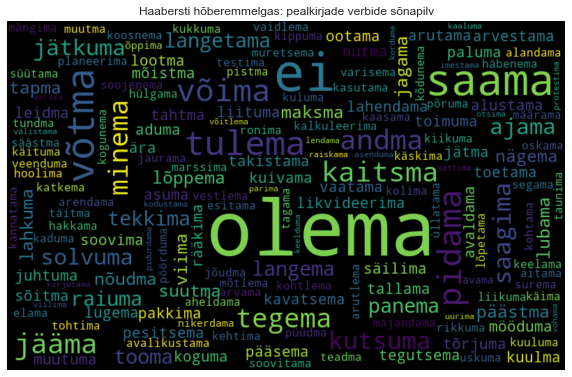

In [31]:
verb_sonad = []
for i in tqdm(range (0, len(data))):
    rida = data.iloc[i]
    tekst = Text(rida[1]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'V':
            verb_sonad.append(sona[0][0])

verb_words = ' '.join(map(str, verb_sonad))

wordcloud_verb = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(verb_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_verb, interpolation='bilinear')
plt.title(konflikt + ": pealkirjade verbide sõnapilv")
plt.axis("off")
plt.savefig("tulemused_" + konflikt +"/" + konflikt + ' joonis4_Pealkirjad_verbid_sonapilv.png')
print(konflikt + ": verbe sõnapilves ", len(verb_sonad))

### 3.2.2 Verbide esinemissagedus artiklite pealkirjades

In [32]:
jaotus4 =pd.DataFrame(verb_sonad, columns=['sõna'])
tabel4 = jaotus4.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:20]
tabel4['osakaal %']= (tabel4['esinemissagedus']/len(verb_sonad)*100)
tabel4_1 = tabel4.style.set_caption(konflikt + ": pealkirjade verbide TOP 20")
tabel4.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel4_Pealkirjad_verbid_TOP_20.xlsx")

In [33]:
tabel4_1

,sõna,esinemissagedus,osakaal %
96,olema,79,16.701903
17,ei,29,6.131078
121,saama,19,4.016913
166,võtma,15,3.171247
149,tulema,12,2.536998
104,pidama,11,2.325581
164,võima,10,2.114165
31,jääma,8,1.691332
6,andma,8,1.691332
36,kaitsma,8,1.691332


### 3.2.3 Verbid artiklite tekstides

100%|████████████████████████████████████████████████████████████████████████████████| 329/329 [01:24<00:00,  3.89it/s]


Haabersti hõberemmelgas: verbe sõnapilves:  31272


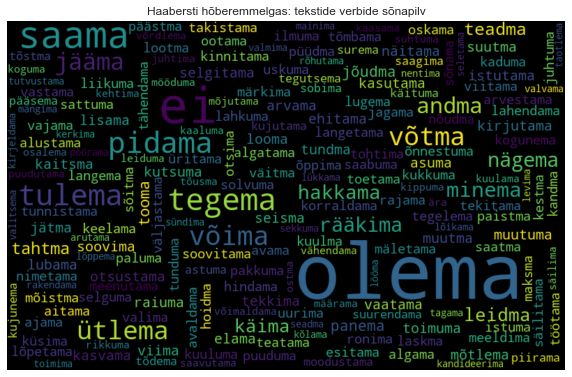

In [34]:
verb_sonad1 = []
for i in tqdm(range (0, len(data))):
    rida = data.iloc[i]
    tekst = Text(rida[2]).tag_layer().morph_analysis['lemma','partofspeech']
    for sona in tekst:
        if sona[0][1] == 'V':
            verb_sonad1.append(sona[0][0])

verb_words1 = ' '.join(map(str, verb_sonad1))

wordcloud_verb1 = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(verb_words1)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_verb1, interpolation='bilinear')
plt.title(konflikt + ": tekstide verbide sõnapilv")
plt.axis("off")
plt.savefig("tulemused_" + konflikt +"/" + konflikt + ' joonis5_Tekstid_verbid_sonapilv.png')
print(konflikt + ": verbe sõnapilves: ", len(verb_sonad1))

### 3.2.4 Verbide esinemissagedus artiklite tekstides

In [35]:
jaotus5 =pd.DataFrame(verb_sonad1, columns=['sõna'])
tabel5 = jaotus5.groupby(['sõna']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:20]
tabel5['osakaal %']= (tabel5['esinemissagedus']/len(verb_sonad1)*100)
tabel5_1 = tabel5.style.set_caption(konflikt + ": tekstide verbide TOP 20")
tabel5.to_excel("tulemused_" + konflikt +"/" + konflikt +  " tabel5_Tekstid_verbid_TOP_20.xlsx")

In [36]:
tabel5_1

,sõna,esinemissagedus,osakaal %
772,olema,7081,22.643259
101,ei,2029,6.488232
1017,saama,1006,3.216935
1206,tegema,649,2.075339
1269,tulema,601,1.921847
844,pidama,599,1.915452
1456,võima,489,1.563699
1467,võtma,471,1.506140
1502,ütlema,468,1.496546
291,jääma,397,1.269506


# 4. Meediakajastus ajalisel skaalal

In [37]:
jaotus6 = data['aasta'].value_counts().sort_index()
tabel6 = pd.DataFrame({'Aasta':jaotus6.index, 'Artikleid':jaotus6.values})
tabel6['Osakaal, %'] = round((tabel6['Artikleid'] / 
                      tabel6['Artikleid'].sum() )* 100, 1)
tabel6_1 = tabel6.style.set_caption(konflikt + ": vaadeldud artikleid aastate lõikes")
tabel6.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel6_Aastate_lõikes.xlsx") 

In [38]:
tabel6_1

,Aasta,Artikleid,"Osakaal, %"
0,2017,260,79.000000
1,2018,42,12.800000
2,2019,10,3.000000
3,2020,6,1.800000
4,2021,11,3.300000


C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


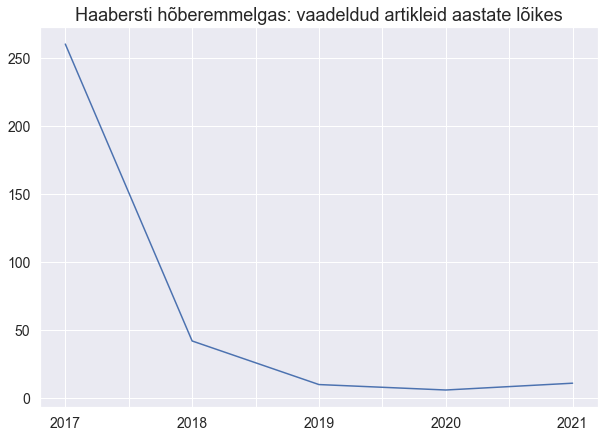

In [39]:
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(10,7))
plt.title(konflikt + ": vaadeldud artikleid aastate lõikes", size=18)
data['aasta'].value_counts().sort_index().plot(ax=ax, kind='line', fontsize=14)
plt.savefig("tulemused_" + konflikt +"/" + konflikt + " joonis6_Aastate_lõikes.png")
plt.show()

In [40]:
jaotus6_proov = data['aasta'].value_counts().sort_index()
tabel6_proov = pd.DataFrame({'Aasta':jaotus6_proov.index, 'Artikleid':jaotus6_proov.values})
tabel6_proov['Osakaal, %'] = round((tabel6_proov['Artikleid'] / 
                      tabel6_proov['Artikleid'].sum() )* 100, 1)
tabel6_1_proov = tabel6_proov.style.set_caption(konflikt + ": vaadeldud artikleid aastate lõikes")
#tabel6.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel6_Aastate_lõikes.xlsx") 

In [41]:
del tabel6_proov['Artikleid']

In [42]:
tabel6_proov

,Aasta,"Osakaal, %"
0,2017,79.0
1,2018,12.8
2,2019,3.0
3,2020,1.8
4,2021,3.3


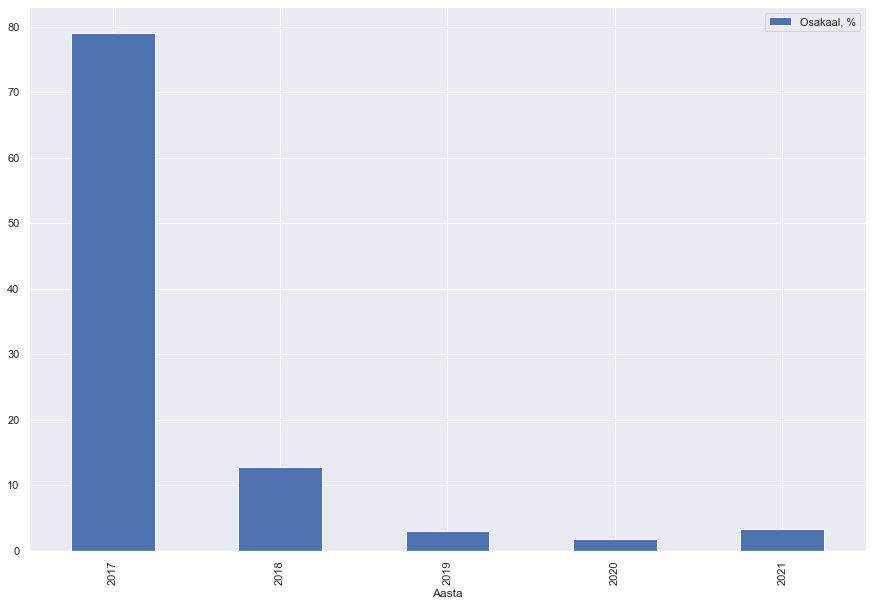

In [43]:
df1 = tabel6_proov.set_index('Aasta') # setting "Years" as index
fig,ax = plt.subplots(figsize=(15,10))
df1.plot(kind='bar',ax=ax)
plt.show()

In [44]:
jaotus7 = data['aasta_kuu'].value_counts().sort_index()
tabel7 = pd.DataFrame({'Aasta':jaotus7.index, 'Artikleid':jaotus7.values})
tabel7['Osakaal, %'] = round((tabel7['Artikleid'] / 
                      tabel7['Artikleid'].sum() )* 100, 1)
tabel7_1 = tabel7.style.set_caption(konflikt + ": vaadeldud artikleid aastate ja kuude lõikes")
tabel7.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel7_Aastate_kuude_lõikes.xlsx") 

In [45]:
tabel7_1

,Aasta,Artikleid,"Osakaal, %"
0,2017-05,5,1.500000
1,2017-06,187,56.800000
2,2017-07,45,13.700000
3,2017-08,5,1.500000
4,2017-09,4,1.200000
5,2017-10,4,1.200000
6,2017-11,4,1.200000
7,2017-12,6,1.800000
8,2018-01,4,1.200000
9,2018-02,3,0.900000


C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


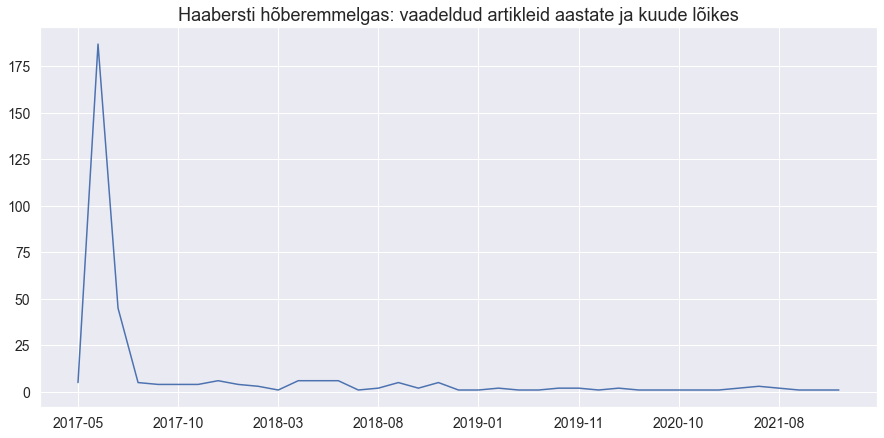

In [46]:
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(15,7))
plt.title(konflikt + ": vaadeldud artikleid aastate ja kuude lõikes", size=18)
data['aasta_kuu'].value_counts().sort_index().plot(ax=ax, kind='line', fontsize=14)
plt.savefig("tulemused_" + konflikt +"/" + konflikt + " joonis7_Aastate_kuude_lõikes.png")
plt.show()

In [47]:
jaotus7_a = data['kuupäev'].value_counts().sort_index()
tabel7_a = pd.DataFrame({'Kuupäev':jaotus7_a.index, 'Artikleid':jaotus7_a.values})
tabel7_a['Osakaal, %'] = round((tabel7_a['Artikleid'] / 
                      tabel7_a['Artikleid'].sum() )* 100, 1)
tabel7_a_1 = tabel7_a.style.set_caption(konflikt + ": vaadeldud artikleid kuupäevade lõikes")
tabel7_a.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel7_a_Kuupäevade_lõikes.xlsx") 

In [48]:
tabel7_a_1

,Kuupäev,Artikleid,"Osakaal, %"
0,2017-05-08,1,0.300000
1,2017-05-26,1,0.300000
2,2017-05-29,1,0.300000
3,2017-05-30,1,0.300000
4,2017-05-31,1,0.300000
5,2017-06-02,1,0.300000
6,2017-06-04,1,0.300000
7,2017-06-05,3,0.900000
8,2017-06-06,4,1.200000
9,2017-06-07,2,0.600000


C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


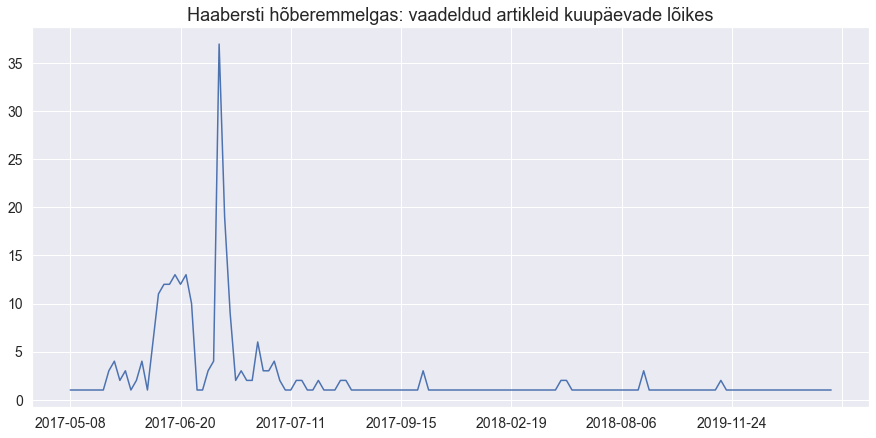

In [49]:
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(15,7))
plt.title(konflikt + ": vaadeldud artikleid kuupäevade lõikes", size=18)
data['kuupäev'].value_counts().sort_index().plot(ax=ax, kind='line', fontsize=14)
plt.savefig("tulemused_" + konflikt +"/" + konflikt + " joonis7_a_Kuupäevade_lõikes.png")
plt.show()

In [50]:
konfl = data[data.code == 1]

In [51]:
data['code'].value_counts()

1    232
2     97
Name: code, dtype: int64

In [52]:
muu = data[data.code == 2]

In [53]:
jaotus7_b = konfl['aasta'].value_counts().sort_index()
tabel7_b = pd.DataFrame({'Aasta':jaotus7_b.index, 'Artikleid':jaotus7_b.values})
tabel7_b['Osakaal, %'] = round((tabel7_b['Artikleid'] / 
                      tabel7_b['Artikleid'].sum() )* 100, 1)
tabel7_b_1 = tabel7_b.style.set_caption(konflikt + ": (konflikt) vaadeldud artikleid aastate lõikes")
tabel7_b.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel7_b_Aastate_lõikes_konflikt.xlsx") 

In [54]:
tabel7_b_1

,Aasta,Artikleid,"Osakaal, %"
0,2017,221,95.300000
1,2018,8,3.400000
2,2019,1,0.400000
3,2020,1,0.400000
4,2021,1,0.400000


C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


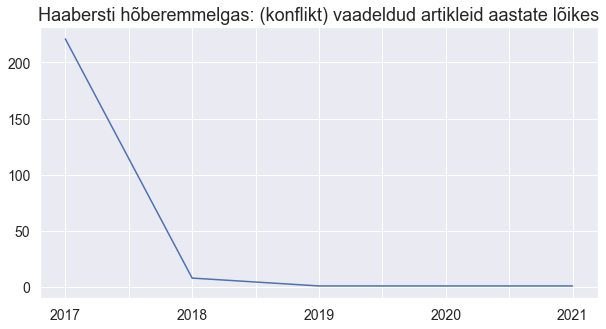

In [55]:
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(10,5))
plt.title(konflikt + ": (konflikt) vaadeldud artikleid aastate lõikes", size=18)
konfl['aasta'].value_counts().sort_index().plot(ax=ax, kind='line', fontsize=14)
plt.savefig("tulemused_" + konflikt +"/" + konflikt + " joonis7_b_Aastate_lõikes_konflikt.png")
plt.show()

In [56]:
jaotus7_c = konfl['aasta_kuu'].value_counts().sort_index()
tabel7_c = pd.DataFrame({'Aasta':jaotus7_c.index, 'Artikleid':jaotus7_c.values})
tabel7_c['Osakaal, %'] = round((tabel7_c['Artikleid'] / 
                      tabel7_c['Artikleid'].sum() )* 100, 1)
tabel7_c_1 = tabel7_c.style.set_caption(konflikt + ": (konflikt) vaadeldud artikleid aastate ja kuude lõikes")
tabel7_c.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel7_c_Aastate_kuude_lõikes_konflikt.xlsx") 

In [57]:
tabel7_c_1

,Aasta,Artikleid,"Osakaal, %"
0,2017-05,4,1.700000
1,2017-06,182,78.400000
2,2017-07,27,11.600000
3,2017-08,2,0.900000
4,2017-09,1,0.400000
5,2017-10,3,1.300000
6,2017-12,2,0.900000
7,2018-05,4,1.700000
8,2018-06,3,1.300000
9,2018-09,1,0.400000


C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


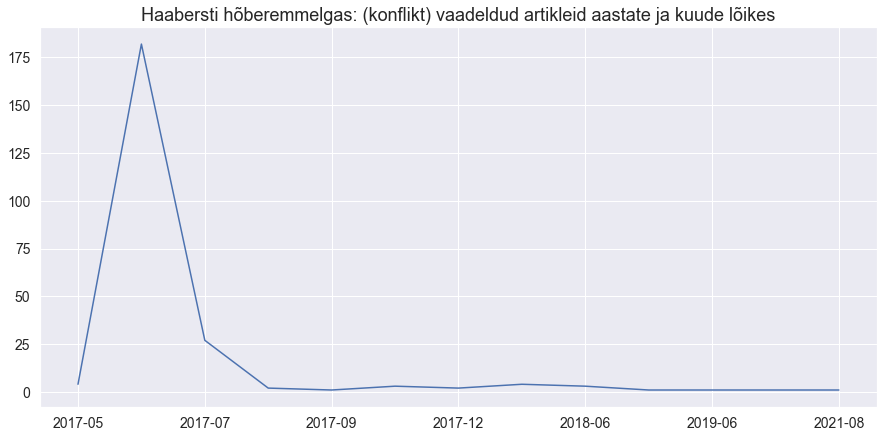

In [58]:
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(15,7))
plt.title(konflikt + ": (konflikt) vaadeldud artikleid aastate ja kuude lõikes", size=18)
konfl['aasta_kuu'].value_counts().sort_index().plot(ax=ax, kind='line', fontsize=14)
plt.savefig("tulemused_" + konflikt +"/" + konflikt + " joonis7_c_Aastate_kuude_lõikes_konflikt.png")
plt.show()

In [59]:
jaotus7_d = konfl['kuupäev'].value_counts().sort_index()
tabel7_d = pd.DataFrame({'Kuupäev':jaotus7_d.index, 'Artikleid':jaotus7_d.values})
tabel7_d['Osakaal, %'] = round((tabel7_d['Artikleid'] / 
                      tabel7_d['Artikleid'].sum() )* 100, 1)
tabel7_d_1 = tabel7_d.style.set_caption(konflikt + ": (konflikt) vaadeldud artikleid kuupäevade lõikes")
tabel7_d.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel7_d_Kuupäevade_lõikes_konflikt.xlsx") 

In [60]:
tabel7_d_1

,Kuupäev,Artikleid,"Osakaal, %"
0,2017-05-26,1,0.400000
1,2017-05-29,1,0.400000
2,2017-05-30,1,0.400000
3,2017-05-31,1,0.400000
4,2017-06-02,1,0.400000
5,2017-06-04,1,0.400000
6,2017-06-05,3,1.300000
7,2017-06-06,4,1.700000
8,2017-06-07,2,0.900000
9,2017-06-09,3,1.300000


C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


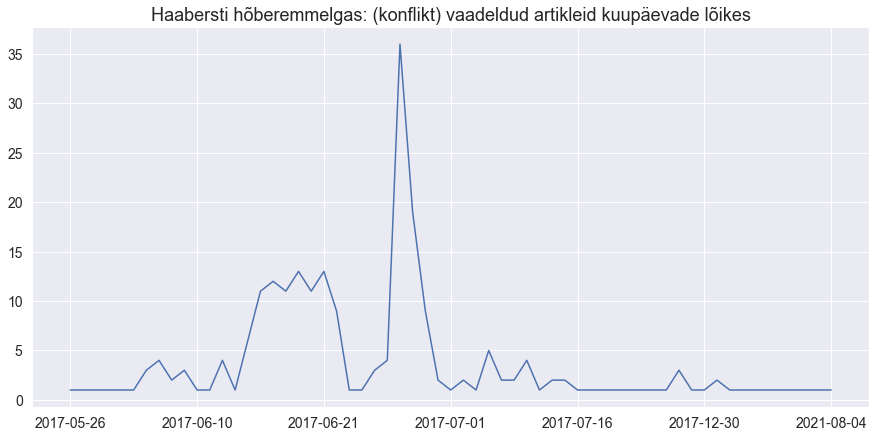

In [61]:
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(15,7))
plt.title(konflikt + ": (konflikt) vaadeldud artikleid kuupäevade lõikes", size=18)
konfl['kuupäev'].value_counts().sort_index().plot(ax=ax, kind='line', fontsize=14)
plt.savefig("tulemused_" + konflikt +"/" + konflikt + " joonis7_d_Kuupäevade_lõikes_konflikt.png")
plt.show()

# 5. Nimed

In [62]:
# Loome uue nimeüksuste tuvastaja 
from estnltk.taggers import NerTagger
ner_tagger = NerTagger()
# Milliseid kihte ner_tagger vajab?
ner_tagger.input_layers

('morph_analysis',)

In [63]:
tekst = data['text'].to_list()

In [64]:
# Otsitakse tekstist nimesid
nimed_labels_d = {}
nimed_texts = []
nimed_labels = []
from estnltk import Text

for k in tekst:
    t= Text(k).tag_layer('morph_analysis')
    # lisame nimeüksuste märgenduse
    ner_tagger.tag(t)
    # leia nimeüksuste liigid
    entity_labels = t.ner[['nertag']]
    # leia nimeüksuste tekstijupid
    entity_texts = [ne.enclosing_text for ne in t.ner]
    # leia nimeüksuste asukohad
    entity_spans = [(ne.start, ne.end) for ne in t.ner]

    # väljastab tuvastatud nimeüksused koos nende asukohtade, tekstijuppide ja liikidega:
    for ne_phrase, ne_label, ne_span in zip(entity_texts, entity_labels, entity_spans):
        print( ne_span, ne_phrase, ne_label )
    nimed_texts.append(entity_texts)
    nimed_labels.append(entity_labels)

(0, 14) Eesti Ekspress ['ORG']
(141, 150) Tallinnas ['LOC']
(151, 171) Toompeal ja Vabaduse ['ORG']
(263, 272) Riigikogu ['ORG']
(638, 650) SILVIA ILVES ['PER']
(800, 805) Urmas ['PER']
(878, 891) Lääne-Eestist ['LOC']
(914, 919) Eesti ['LOC']
(932, 937) Urmas ['PER']
(971, 986) Indrek Tarandit ['PER']
(1029, 1041) Silvia Ilves ['PER']
(1857, 1865) Toompeal ['ORG']
(2068, 2075) Katrina ['PER']
(2187, 2197) Tallinnast ['LOC']
(2765, 2774) Mari-Anna ['PER']
(2803, 2813) Mari-Annal ['LOC']
(2861, 2868) Evelini ['PER']
(2872, 2877) Argot ['PER']
(2897, 2905) Toompeal ['ORG']
(3941, 3954) Argoja Evelin ['ORG']
(4028, 4037) Ekspressi ['ORG']
(4233, 4245) Erik Moorale ['PER']
(4328, 4337) Evelinist ['PER']
(4341, 4347) Argost ['PER']
(4395, 4401) Evemaa ['PER']
(4403, 4409) Evelin ['PER']
(4434, 4438) Argo ['PER']
(4450, 4457) Evelini ['PER']
(4461, 4465) Argo ['PER']
(4480, 4491) Veiko Huuse ['PER']
(4509, 4513) Vaba ['PER']
(4514, 4519) Eesti ['LOC']
(4541, 4546) Argot ['PER']
(4550, 4557) 

(11, 41) Riigimetsa Majandamise Keskuse ['ORG']
(43, 46) RMK ['ORG']
(48, 56) Tallinna ['LOC']
(147, 157) Haaberstis ['LOC']
(218, 227) Haabersti ['LOC']
(382, 406) Eesti Tööõpetajate Selts ['ORG']
(653, 678) Eesti Tööõpetajate Seltsi ['ORG']
(694, 705) Jürgo Nooni ['PER']
(747, 759) RMK Tallinna ['ORG']
(48, 58) Ignar Fjuk ['PER']
(81, 111) Tallinna linnaplaneerimisameti ['ORG']
(147, 155) Tallinna ['LOC']
(463, 484) Tallinna linnaameteid ['ORG']
(516, 528) Keskerakonna ['ORG']
(544, 548) Fjuk ['PER']
(610, 634) Tallinna linnavalitsuses ['ORG']
(645, 660) Reformierakonna ['ORG']
(758, 762) Fjuk ['PER']
(869, 875) Eestit ['LOC']
(968, 973) Fjuki ['PER']
(1215, 1219) Fjuk ['PER']
(1220, 1230) Haaberstis ['LOC']
(1379, 1383) Fjuk ['PER']
(1394, 1403) Haabersti ['LOC']
(1652, 1657) Fjuki ['PER']
(2136, 2140) Fjuk ['PER']
(2482, 2486) Fjuk ['PER']
(2541, 2546) Fjuki ['PER']
(3058, 3062) Fjuk ['PER']
(3064, 3068) Fjuk ['PER']
(3469, 3473) Fjuk ['PER']
(101, 113) Rail Balticu ['PER']
(121, 1

(104, 118) Peeter Laurits ['PER']
(620, 628) Lauritsa ['PER']
(647, 660) Vaal Galeriis ['ORG']
(729, 739) Andres Lõo ['PER']
(744, 758) Peeter Laurits ['PER']
(824, 831) Vormilt ['PER']
(986, 990) NASA ['ORG']
(1060, 1068) Lauritsa ['PER']
(1327, 1330) Lõo ['LOC']
(1820, 1830) Andres Lõo ['PER']
(1832, 1841) Ekstaas 2 ['ORG']
(2096, 2109) John Wyndhami ['PER']
(2306, 2311) Maale ['LOC']
(2424, 2433) Haabersti ['LOC']
(2530, 2535) Eesti ['LOC']
(2695, 2704) Haabersti ['LOC']
(3671, 3679) Simakilt ['PER']
(3826, 3840) Peeter Laurits ['PER']
(3844, 3850) Andres ['PER']
(3851, 3854) Lõo ['PER']
(3868, 3880) Sander Somma ['PER']
(3882, 3894) Nathan Tulve ['PER']
(3896, 3912) Johanna Ruukholm ['PER']
(3914, 3919) Rommi ['PER']
(3920, 3926) Ruttas ['PER']
(3927, 3940) Vaal Galeriis ['ORG']
(201, 211) Riigikogul ['ORG']
(218, 230) Rail Balticu ['PER']
(383, 395) Arne Aderist ['PER']
(401, 415) Airi Värnikuni ['PER']
(541, 550) Riigikogu ['ORG']
(566, 578) Rail Balticu ['PER']
(629, 638) Haaber

(0, 25) Eesti Dendroloogia Seltsi ['ORG']
(48, 61) Aino Aaspõllu ['PER']
(72, 81) Haabersti ['LOC']
(141, 149) Aaspõllu ['PER']
(295, 308) Aino Aaspõllu ['PER']
(433, 442) Haabersti ['LOC']
(483, 489) Eestis ['LOC']
(511, 520) Tallinnas ['LOC']
(532, 540) Tallinna ['LOC']
(567, 573) Šnelli ['LOC']
(587, 596) Haabersti ['LOC']
(628, 632) ERRi ['ORG']
(914, 922) Aaspõllu ['PER']
(925, 934) Haabersti ['LOC']
(1320, 1329) Haabersti ['LOC']
(1439, 1461) Tallinna keskkonnaamet ['ORG']
(1641, 1651) Facebookis ['LOC']
(1769, 1778) Haabersti ['LOC']
(1932, 1950) Eerik-Niiles Kross ['PER']
(1952, 1964) Artur Talvik ['PER']
(1966, 1975) Mart Nutt ['PER']
(1979, 1991) Rainer Vakra ['PER']
(2069, 2078) Haabersti ['LOC']
(0, 9) Haabersti ['LOC']
(364, 369) Delfi ['ORG']
(572, 577) Delfi ['ORG']
(887, 907) Facbooki gruppidesse ['PER']
(909, 914) Eesti ['LOC']
(932, 944) Ema Kogukond ['PER']
(1168, 1178) Facebookis ['LOC']
(1606, 1615) Haabersti ['LOC']
(1790, 1812) Tallinna keskkonnaamet ['ORG']
(198

(160, 163) SDE ['ORG']
(170, 180) Siim Tuisk ['PER']
(399, 404) Tuisk ['PER']
(405, 412) Delfile ['ORG']
(576, 581) Tuisu ['PER']
(777, 782) Tuisk ['PER']
(1073, 1082) Facebooki ['PER']
(1099, 1107) Twitteri ['LOC']
(1266, 1271) Tuisu ['PER']
(2156, 2173) Õismäele politsei ['ORG']
(2873, 2878) Tuisk ['PER']
(2921, 2927) Õismäe ['LOC']
(2992, 2998) Eestis ['LOC']
(3047, 3076) Nabala-Tuhala looduskaitseala ['LOC']
(143, 152) Haabersti ['LOC']
(280, 288) Tallinna ['LOC']
(498, 503) Eesti ['LOC']
(571, 580) Haabersti ['LOC']
(633, 642) Haabersti ['LOC']
(1839, 1850) Haaberstist ['LOC']
(2265, 2274) Haabersti ['LOC']
(2367, 2375) Tallinna ['LOC']
(2559, 2568) Haabersti ['LOC']
(2574, 2582) Tallinna ['LOC']
(2854, 2864) Haaberstis ['LOC']
(2872, 2885) Saku Suurhall ['ORG']
(2887, 2892) Škoda ['ORG']
(2902, 2913) My Fitnessi ['ORG']
(2927, 2940) Rocca al Mare ['LOC']
(2958, 2971) Rocca al Mare ['LOC']
(2987, 3007) Eesti Vabaõhumuuseum ['ORG']
(3011, 3019) Tallinna ['LOC']
(3248, 3257) Haabers

(43, 58) Soome Vabariigi ['LOC']
(101, 113) Mario Draghi ['PER']
(121, 138) Euroopa Keskpanga ['ORG']
(149, 158) Tallinnas ['LOC']
(188, 193) Eesti ['LOC']
(196, 202) Belgia ['LOC']
(204, 210) Belgia ['LOC']
(265, 273) Belgiaga ['LOC']
(317, 322) Eesti ['LOC']
(335, 350) Ragnar Klavanit ['PER']
(359, 365) Belgia ['LOC']
(407, 415) Tallinna ['LOC']
(438, 448) Eestimaale ['LOC']
(494, 504) Jüri Ratas ['PER']
(573, 578) Soome ['LOC']
(582, 587) Eesti ['LOC']
(723, 732) Haabersti ['LOC']
(828, 840) Rainer Vakra ['PER']
(842, 851) Haabersti ['LOC']
(925, 936) Jan Uuspõld ['PER']
(946, 961) Eesti Päevalehe ['ORG']
(1010, 1024) Renault Trafic ['PER']
(1041, 1058) Jeep Cherokee 'ga ['PER']
(39, 47) Paldiski ['LOC']
(65, 74) Haabersti ['LOC']
(239, 245) Vegard ['PER']
(645, 657) Rainer Vakra ['PER']
(832, 855) Tallinna kommunaalameti ['ORG']
(902, 913) Heiki Hanso ['PER']
(956, 965) Riigikogu ['ORG']
(993, 1005) Rainer Vakra ['PER']
(1058, 1067) Haabersti ['LOC']
(1130, 1143) Tallinna linn ['LO

(0, 5) Eesti ['LOC']
(91, 105) Edgar Savisaar ['PER']
(127, 131) Vene ['LOC']
(144, 147) USA ['LOC']
(383, 388) Eesti ['LOC']
(413, 422) Tammsaare ['PER']
(615, 622) Lihulas ['LOC']
(730, 739) Lihulasse ['LOC']
(778, 783) Saksa ['LOC']
(1024, 1035) Res Publica ['ORG']
(1063, 1067) IRLi ['ORG']
(1141, 1150) Tallinnas ['LOC']
(1158, 1164) Sakala ['LOC']
(1240, 1245) Eesti ['LOC']
(1353, 1365) Eesti riigis ['LOC']
(1417, 1423) Sakala ['LOC']
(1572, 1577) Eesti ['LOC']
(1803, 1813) Haaberstis ['LOC']
(2423, 2435) Rail Balticu ['PER']
(2611, 2617) Emajõe ['LOC']
(2828, 2837) Pandivere ['LOC']
(3044, 3054) Kalevipoeg ['PER']
(3203, 3213) Kalevipoeg ['PER']
(138, 151) Tõnu Karjatse ['PER']
(167, 178) Lääne-harju ['LOC']
(202, 217) Veiko Raudlaise ['PER']
(68, 77) Tallinnas ['LOC']
(78, 87) Haabersti ['LOC']
(950, 967) Päästeameti Põhja ['ORG']
(991, 1004) Annika Koppel ['PER']
(1005, 1012) ERR-ile ['ORG']
(1317, 1322) ERR-i ['ORG']
(1879, 1891) Rainer Vakra ['PER']
(2032, 2040) Tallinna ['LOC

(287, 293) Krulli ['ORG']
(303, 312) Postimehe ['ORG']
(340, 349) Kaplinski ['PER']
(353, 361) Õnnepalu ['PER']
(1719, 1725) Krulli ['LOC']
(1845, 1858) Aimar Ventsel ['PER']
(3211, 3217) Krulli ['PER']
(3846, 3852) Krulli ['PER']
(3899, 3902) SKT ['ORG']
(4246, 4255) Kaplinski ['PER']
(4259, 4267) Õnnepalu ['PER']
(4824, 4829) Eesti ['LOC']
(5417, 5426) Pomerants ['PER']
(5431, 5437) Kallas ['PER']
(5913, 5918) Krull ['PER']
(0, 9) Haabersti ['LOC']
(61, 76) Toomas F. Arult ['PER']
(78, 84) Pärnus ['LOC']
(116, 122) Tartus ['LOC']
(154, 159) Võrus ['LOC']
(191, 200) Viljandis ['LOC']
(269, 275) Narvas ['LOC']
(307, 318) Kuressaares ['LOC']
(350, 355) Elvas ['LOC']
(47, 88) Eestimaa Roheliste kohalike omavalitsuste ['ORG']
(288, 335) Stockholmi Keskkonnainstituudi Tallinna Keskuse ['ORG']
(337, 348) SEI Tallinn ['ORG']
(373, 381) Tallinna ['LOC']
(386, 391) Tartu ['LOC']
(606, 615) Tallinnas ['LOC']
(630, 644) Reformierakond ['ORG']
(646, 673) Sotsiaaldemokraalit Erakond ['ORG']
(675, 

(0, 8) Paldiski ['LOC']
(87, 95) Tallinna ['LOC']
(177, 185) Paldiski ['LOC']
(267, 280) keskkonnaamet ['ORG']
(314, 322) Paldiski ['LOC']
(401, 409) Tallinna ['LOC']
(491, 499) Paldiski ['LOC']
(581, 594) keskkonnaamet ['ORG']
(698, 703) Eesti ['LOC']
(756, 764) Tallinna ['LOC']
(1, 9) Tallinna ['LOC']
(123, 128) Eesti ['LOC']
(181, 189) Tallinna ['LOC']
(349, 357) Tallinna ['LOC']
(414, 428) keskkonnaameti ['ORG']
(444, 454) Sille Ader ['PER']
(493, 501) Paldiski ['LOC']
(583, 596) keskkonnaamet ['ORG']
(644, 657) Hendrik Relve ['PER']
(170, 178) Õhtuleht ['ORG']
(200, 209) Facebooki ['LOC']
(482, 487) Eesti ['LOC']
(267, 277) Haaberstis ['LOC']
(0, 18) Tallinna Haabersti ['ORG']
(83, 91) Paldiski ['LOC']
(367, 371) Mati ['PER']
(375, 378) Ivo ['PER']
(658, 662) Mati ['PER']
(767, 777) Haaberstis ['LOC']
(854, 862) Paldiski ['LOC']
(931, 939) Tallinna ['LOC']
(943, 948) Keila ['LOC']
(1474, 1478) Aavo ['PER']
(2323, 2330) Norrast ['LOC']
(3409, 3422) Keskkonnaamet ['ORG']
(3590, 3596

(131, 158) Eestimaa Roheliste Erakonna ['ORG']
(168, 185) Züleyxa Izmailova ['PER']
(245, 255) Haaberstis ['LOC']
(681, 689) Paldiski ['LOC']
(813, 823) Rein Ratas ['ORG']
(981, 986) Eesti ['LOC']
(1194, 1200) Eestis ['LOC']
(1205, 1212) Euroopa ['LOC']
(1626, 1631) Eesti ['LOC']
(1888, 1893) Riigi ['ORG']
(1897, 1905) Tallinna ['LOC']
(1926, 1935) Haabersti ['LOC']
(2281, 2292) Rohelistega ['LOC']
(9, 20) Heiki Hanso ['PER']
(37, 46) Haabersti ['ORG']
(252, 261) Haabersti ['LOC']
(689, 694) Eesti ['LOC']
(735, 749) Eesti Vabariik ['LOC']
(859, 864) Hanso ['PER']
(866, 871) Hanso ['PER']
(21, 30) Haabersti ['LOC']
(1059, 1070) Marko Veide ['PER']
(2276, 2293) Vegard Emanuelson ['PER']
(3302, 3311) Haabersti ['LOC']
(3587, 3596) Haabersti ['LOC']
(3745, 3754) Haabersti ['LOC']
(3853, 3862) euroliidu ['ORG']
(3914, 3923) Relo Ligi ['ORG']
(4535, 4537) EV ['ORG']
(4571, 4575) Ligi ['PER']
(4604, 4618) Reio Vesiallik ['PER']
(4839, 4849) Facebookil ['LOC']
(5007, 5018) Heiki Hanso ['PER']


(707, 714) Eestist ['LOC']
(72, 81) Guardiani ['ORG']
(87, 92) Saksa ['LOC']
(609, 615) Isamaa ['ORG']
(678, 684) Emamaa ['LOC']
(1249, 1254) Eesti ['LOC']
(1375, 1380) Eesti ['LOC']
(2562, 2580) Universumi Kuninga ['PER']
(2756, 2765) Saksamaal ['LOC']
(3325, 3330) Eesti ['LOC']
(4274, 4278) Kaos ['PER']
(4279, 4284) Põrgu ['LOC']
(5185, 5190) Eesti ['LOC']
(5340, 5347) Venemaa ['LOC']
(5349, 5357) Eestimaa ['LOC']
(5755, 5761) Uberid ['ORG']
(6617, 6626) Suure Isa ['ORG']
(7311, 7319) Eestimaa ['LOC']
(76, 86) Haaberstis ['LOC']
(84, 101) Eesti Metsa Abiks ['ORG']
(103, 106) EMA ['PER']
(149, 158) Tallinnas ['LOC']
(159, 169) Haaberstis ['LOC']
(225, 228) BNS ['ORG']
(520, 530) Linda-Mari ['PER']
(531, 535) Väli ['PER']
(540, 549) Facebooki ['PER']
(830, 834) Väli ['PER']
(966, 975) Haabersti ['LOC']
(1185, 1189) Väli ['PER']
(1511, 1517) Eestis ['LOC']
(1556, 1560) Väli ['PER']
(1742, 1752) Marie Aava ['PER']
(2067, 2071) Aava ['PER']
(37, 48) Nordecon AS ['ORG']
(298, 307) Haaberst

(44, 53) Haabersti ['LOC']
(197, 206) Haabersti ['LOC']
(1111, 1120) Haabersti ['LOC']
(1182, 1187) Eesti ['LOC']
(1222, 1244) Keskkonnaministeeriumi ['ORG']
(1246, 1260) Tallinna Linna ['LOC']
(1498, 1507) Haabersti ['LOC']
(2133, 2142) Haabersti ['LOC']
(2470, 2480) Haaberstis ['LOC']
(0, 9) Haabersti ['LOC']
(372, 378) Eestis ['LOC']
(631, 638) Kakumäe ['LOC']
(640, 648) Vahepere ['LOC']
(650, 656) Tiskre ['LOC']
(660, 668) Tabasalu ['LOC']
(847, 859) Vabaõhukooli ['ORG']
(1159, 1168) Haabersti ['LOC']
(1514, 1523) Haabersti ['LOC']
(2405, 2426) Keskkonnaministeerium ['ORG']
(32, 38) Õismäe ['LOC']
(84, 93) Haabersti ['LOC']
(252, 276) Keskkonnaministeeriumile ['ORG']
(369, 375) Maxima ['PER']
(403, 411) Paldiski ['LOC']
(635, 641) Õismäe ['LOC']
(663, 672) Haabersti ['LOC']
(702, 714) Keskerakonna ['ORG']
(1202, 1246) Eesti Konservatiivse Rahvaerakonna Haabersti ['ORG']
(1261, 1271) Eda Rüütli ['PER']
(1356, 1370) EKRE Haabersti ['ORG']
(1388, 1398) Eda Rüütli ['PER']
(1402, 1410) 

(76, 85) Tallinnas ['LOC']
(278, 283) BNS-i ['ORG']
(551, 554) BNS ['ORG']
(640, 657) Eesti Metsa Abiks ['ORG']
(659, 662) EMA ['PER']
(705, 714) Tallinnas ['LOC']
(715, 725) Haaberstis ['LOC']
(1062, 1072) Linda-Mari ['PER']
(1073, 1077) Väli ['PER']
(1082, 1091) Facebooki ['PER']
(1229, 1238) Haabersti ['LOC']
(1448, 1452) Väli ['PER']
(1634, 1644) Marie Aava ['PER']
(1959, 1963) Aava ['PER']
(18, 32) Toomas Trapido ['PER']
(40, 45) ERR-i ['ORG']
(83, 92) Haabersti ['LOC']
(230, 242) Vikerraadios ['ORG']
(277, 284) Trapido ['PER']
(285, 295) Facebookis ['LOC']
(367, 376) Haabersti ['LOC']
(567, 570) BNS ['ORG']
(1010, 1019) Haabersti ['LOC']
(1098, 1105) Trapido ['PER']
(1134, 1145) Vikerraadio ['ORG']
(1231, 1237) Eestis ['LOC']
(1324, 1329) Eesti ['LOC']
(1349, 1356) Euroopa ['LOC']
(1417, 1429) Peeter Helme ['PER']
(1440, 1449) Haabersti ['LOC']
(1696, 1709) Merilin Pärli ['PER']
(1832, 1841) Haabersti ['LOC']
(1996, 2001) Pärli ['PER']
(0, 9) Tallinnas ['LOC']
(10, 18) Paldiski [

(0, 13) Heldur Sandri ['PER']
(199, 210) RIIN MAGNUS ['PER']
(288, 301) Heldur Sander ['PER']
(343, 348) Eesti ['LOC']
(422, 428) Sandri ['PER']
(694, 701) Tallinn ['LOC']
(703, 708) Pärnu ['LOC']
(712, 720) Haapsalu ['LOC']
(1081, 1094) Koeru-Aruküla ['LOC']
(1144, 1152) Tallinna ['LOC']
(1434, 1442) Tallinna ['LOC']
(1793, 1798) Eesti ['LOC']
(2005, 2014) Tallinnas ['LOC']
(2067, 2079) Kindergarten ['ORG']
(2084, 2092) Toompeal ['ORG']
(2394, 2403) Tallinnas ['LOC']
(2716, 2725) Tallinnas ['LOC']
(2893, 2902) Tallinnas ['LOC']
(2964, 2972) Koplisse ['LOC']
(2987, 2994) Venemaa ['LOC']
(3074, 3079) XVIII ['ORG']
(3150, 3155) Kopli ['LOC']
(3200, 3209) Nõukogude ['LOC']
(3359, 3378) Tallinnas Tammsaare ['ORG']
(3504, 3512) Tallinna ['LOC']
(3725, 3731) Kaarli ['PER']
(3767, 3776) Haabersti ['LOC']
(4113, 4118) Eesti ['LOC']
(4191, 4206) Eesti Vabariigi ['LOC']
(4701, 4710) Tallinnas ['LOC']
(4712, 4718) Nõmmel ['LOC']
(4720, 4729) Viljandis ['LOC']
(4812, 4817) Pätsi ['PER']
(4872, 488

(0, 9) Haabersti ['LOC']
(672, 678) Õismäe ['LOC']
(709, 722) MTÜ Haabersti ['ORG']
(749, 758) Riigikogu ['ORG']
(797, 806) Haabersti ['LOC']
(0, 5) Eesti ['LOC']
(37, 47) Haaberstis ['LOC']
(218, 227) riigikogu ['ORG']
(236, 245) Mart Nutt ['PER']
(247, 265) Eerik-Niiles Kross ['PER']
(267, 279) Artur Talvik ['PER']
(283, 295) Rainer Vakra ['PER']
(347, 361) Tallinna linna ['LOC']
(621, 630) Haabersti ['LOC']
(785, 793) Paldiski ['LOC']
(1070, 1079) Haabersti ['LOC']
(1531, 1544) Peeter Ernits ['PER']
(1641, 1656) Reformierakonna ['ORG']
(1708, 1722) Kristen Michal ['PER']
(18, 27) Haabersti ['LOC']
(188, 204) Kristel Vilbaste ['PER']
(515, 520) Eesti ['LOC']
(1799, 1807) Saaremaa ['LOC']
(1829, 1836) Koidula ['LOC']
(2099, 2108) Haabersti ['LOC']
(2607, 2629) Lääne- ja Ida-Saksamaa ['LOC']
(3331, 3336) Eesti ['LOC']
(3882, 3891) Haabersti ['LOC']
(3967, 3976) Haabersti ['LOC']
(0, 45) Riigimetsa Majandamise Keskuse Tallinna büroo ['ORG']
(150, 160) Haaberstis ['LOC']
(230, 236) Õismä

(23, 30) Eestile ['LOC']
(101, 115) Tabivere valda ['LOC']
(273, 281) Erakonna ['ORG']
(282, 300) Eestimaa Rohelised ['ORG']
(316, 328) Marko Kaasik ['PER']
(348, 354) Tartus ['LOC']
(428, 434) Eestis ['LOC']
(783, 799) Eesti Vabariigis ['LOC']
(1461, 1470) Haabersti ['LOC']
(2074, 2089) Nõukogude Liidu ['LOC']
(2303, 2312) Haabersti ['LOC']
(2466, 2471) Eesti ['LOC']
(2488, 2493) Eesti ['LOC']
(2511, 2517) Auvere ['LOC']
(2648, 2663) Euroopa Liidust ['ORG']
(2678, 2693) Eesti Energialt ['ORG']
(2791, 2802) Rail Baltic ['PER']
(2828, 2841) Euroopa Liidu ['ORG']
(3016, 3021) Pärnu ['LOC']
(3055, 3065) Tartu-Riia ['LOC']
(3289, 3301) Rail Balticu ['PER']
(3483, 3488) Balti ['LOC']
(3499, 3511) Rail Balticu ['PER']
(3645, 3658) Euroopa Liidu ['ORG']
(3858, 3865) Euroopa ['LOC']
(4027, 4035) Euroopas ['LOC']
(4043, 4049) Eestis ['LOC']
(4136, 4142) EstFor ['ORG']
(4170, 4175) Eesti ['LOC']
(4788, 4794) Eestis ['LOC']
(4798, 4806) Euroopas ['LOC']
(5143, 5148) Eesti ['LOC']
(14, 23) Haabers

(33, 42) Tallinnas ['LOC']
(43, 53) Haaberstis ['LOC']
(435, 444) Riigikogu ['ORG']
(453, 471) Eerik-Niiles Kross ['PER']
(473, 485) Artur Talvik ['PER']
(487, 496) Mart Nutt ['PER']
(500, 512) Rainer Vakra ['PER']
(594, 603) Haabersti ['LOC']
(1076, 1086) Seiko Kuik ['PER']
(1093, 1099) BNSile ['ORG']
(1388, 1392) Kuik ['PER']
(2205, 2222) Eesti Metsa Abiks ['ORG']
(2224, 2227) EMA ['PER']
(2562, 2572) Linda-Mari ['PER']
(2573, 2577) Väli ['PER']
(2582, 2591) Facebooki ['PER']
(2872, 2876) Väli ['PER']
(2912, 2921) Postimees ['ORG']
(3019, 3036) Põhja prefektuuri ['ORG']
(3052, 3062) Marie Aava ['PER']
(22, 50) RMK Tallinna büroo aatriumis ['ORG']
(123, 133) Haaberstis ['LOC']
(230, 258) RMK Tallinna büroo aatriumis ['ORG']
(309, 318) Haabersti ['LOC']
(0, 6) Õismäe ['LOC']
(37, 50) MTÜ Haabersti ['ORG']
(83, 92) Haabersti ['LOC']
(371, 375) MTÜ. ['ORG']
(475, 487) Väike-Õismäe ['LOC']
(533, 540) Kakumäe ['LOC']
(544, 550) Tiskre ['LOC']
(582, 593) Lääne-Harju ['LOC']
(649, 657) Paldi

(325, 333) Tallinna ['LOC']
(416, 424) Tallinna ['LOC']
(554, 559) Eesti ['LOC']
(572, 580) Rebalale ['PER']
(736, 742) Rebala ['LOC']
(750, 759) Tiia Välk ['PER']
(766, 775) Tallinnas ['LOC']
(880, 886) Rebala ['LOC']
(1023, 1037) Rebala külades ['LOC']
(1068, 1077) Tiia Välk ['PER']
(1293, 1299) Rebala ['LOC']
(1321, 1330) Tiia Välk ['PER']
(1761, 1765) Välk ['PER']
(1793, 1800) Rebalas ['LOC']
(1802, 1808) Eestis ['LOC']
(1927, 1940) Kadi Laanemäe ['PER']
(2691, 2704) Kadi Laanemäe ['PER']
(2754, 2758) Kadi ['PER']
(3117, 3125) Laanemäe ['PER']
(3845, 3853) Laanemäe ['PER']
(4036, 4046) Raivo Rand ['PER']
(4239, 4243) Rand ['PER']
(4329, 4337) Tallinna ['LOC']
(5214, 5224) Tallinnast ['LOC']
(5241, 5247) Valgas ['LOC']
(5411, 5417) Valgas ['LOC']
(5582, 5588) Valgas ['LOC']
(5652, 5657) Valga ['LOC']
(5785, 5791) Eestis ['LOC']
(5827, 5842) Tallinnas Umami ['ORG']
(5862, 5868) Kadaka ['PER']
(6013, 6018) Umami ['PER']
(6044, 6059) Kristjan Päeske ['PER']
(6505, 6511) Päeske ['PER']


(21, 49) Tallinna munitsipaalpolitsei ['ORG']
(50, 75) Toompeal Aleksandr Nevski ['ORG']
(426, 435) Haabersti ['LOC']
(464, 472) Mati Oja ['PER']
(589, 605) Kersti Kaljulaid ['PER']
(612, 622) Facebookis ['LOC']
(649, 659) Facebookis ['LOC']
(767, 775) Vabaduse ['ORG']
(920, 935) Oja Postimehele ['ORG']
(67, 76) Haabersti ['LOC']
(177, 186) Haabersti ['LOC']
(201, 216) Marek Jürgenson ['PER']
(218, 229) Keskerakond ['ORG']
(372, 381) Haabersti ['LOC']
(509, 517) Tallinna ['LOC']
(730, 735) Eesti ['LOC']
(803, 812) Haabersti ['LOC']
(2385, 2394) Haabersti ['LOC']
(2487, 2495) Tallinna ['LOC']
(2682, 2691) Haabersti ['LOC']
(2696, 2704) Tallinna ['LOC']
(2970, 2980) Haaberstis ['LOC']
(2988, 3001) Saku Suurhall ['ORG']
(3003, 3008) Škoda ['ORG']
(3018, 3029) My Fitnessi ['ORG']
(3043, 3056) Rocca al Mare ['LOC']
(3074, 3087) Rocca al Mare ['LOC']
(3103, 3123) Eesti Vabaõhumuuseum ['ORG']
(3127, 3135) Tallinna ['LOC']
(3345, 3354) Haabersti ['LOC']
(3449, 3458) Haabersti ['LOC']
(3523, 35

(0, 13) Kirde-Euroopa ['LOC']
(45, 54) Valgevene ['LOC']
(65, 72) Poolale ['LOC']
(217, 231) Evelyn Kaldoja ['PER']
(233, 249) Varssavi-Tallinn ['LOC']
(289, 296) Eestist ['LOC']
(298, 304) Lätist ['LOC']
(309, 323) LoodeVenemaast ['LOC']
(356, 362) Poolas ['LOC']
(366, 376) Valgevenes ['LOC']
(383, 393) Białowieża ['LOC']
(820, 825) Saksa ['LOC']
(879, 886) Euroopa ['LOC']
(905, 912) Euroopa ['LOC']
(954, 968) Poola Vabariik ['LOC']
(1135, 1143) Euroopat ['LOC']
(1235, 1240) Saksa ['LOC']
(1275, 1279) NSVL ['LOC']
(1313, 1323) Białowieża ['LOC']
(1343, 1353) Białowieża ['PER']
(1364, 1369) Poola ['LOC']
(1407, 1410) PiS ['ORG']
(1619, 1624) Poola ['LOC']
(1642, 1657) Krzysztof Cibor ['PER']
(1833, 1838) Cibor ['PER']
(1938, 1950) Donald Tuski ['PER']
(1979, 1997) Andrzej Kraszewski ['PER']
(2020, 2025) Poola ['LOC']
(2103, 2112) Valgevene ['LOC']
(2172, 2177) Poola ['LOC']
(2191, 2203) Białowieżast ['LOC']
(2340, 2350) Kraszewski ['PER']
(2415, 2427) Białowieżale ['LOC']
(2502, 2507) 

(1, 9) Saaremaa ['LOC']
(209, 222) Vambola Paavo ['PER']
(368, 376) Saaremaa ['LOC']
(593, 600) Muhumaa ['LOC']
(1191, 1197) Elroni ['LOC']
(1208, 1223) Tallin-na-Tartu ['LOC']
(1670, 1676) Õismäe ['LOC']
(1875, 1881) Natura ['ORG']
(2275, 2282) Virtsus ['LOC']
(2635, 2640) Taani ['LOC']
(2901, 2910) Saaremaal ['LOC']
(3079, 3088) Saaremaal ['LOC']
(3252, 3259) Muhumaa ['LOC']
(3410, 3416) Soomes ['LOC']
(12, 25) Astrid Kannel ['PER']
(243, 249) Kannel ['PER']
(301, 315) Zuzu Izmailova ['PER']
(389, 397) Tallinna ['LOC']
(407, 416) Taavi Aas ['PER']
(702, 705) Aas ['PER']
(743, 751) Tallinna ['LOC']
(875, 888) Narva maantee ['LOC']
(1045, 1048) Aas ['PER']
(1223, 1240) Züleyxa Izmailova ['PER']
(1640, 1657) Züleyxa Izmailova ['PER']
(2017, 2039) Tallinna Kommunaalamet ['ORG']
(0, 9) Izmailova ['PER']
(16, 18) Co ['LOC']
(48, 59) Keskerakond ['ORG']
(115, 126) Rohelistega ['ORG']
(244, 257) Ahto Lobjakas ['PER']
(276, 286) Jüri Ratas ['PER']
(294, 306) Keskerakonna ['ORG']
(307, 315) Ta

(159, 164) Eesti ['LOC']
(265, 282) Eesti Maaülikooli ['ORG']
(290, 299) Jüri Liiv ['PER']
(328, 333) Eesti ['LOC']
(627, 637) Urmas Vadi ['PER']
(674, 689) Vargamäe Andres ['PER']
(822, 830) Eestimaa ['LOC']
(997, 1002) Eesti ['LOC']
(1346, 1362) Tartu Ülikoolist ['ORG']
(1363, 1368) Eesti ['LOC']
(2241, 2249) Venemaal ['LOC']
(2571, 2576) Eesti ['LOC']
(3287, 3293) Eestis ['LOC']
(5521, 5527) Eestis ['LOC']
(6394, 6400) Eestis ['LOC']
(6465, 6476) Valgevenest ['LOC']
(6764, 6770) Soomes ['LOC']
(7105, 7111) Soomes ['LOC']
(7404, 7419) Tartu Ülikoolis ['ORG']
(7423, 7441) Eesti Maaülikoolis ['ORG']
(7773, 7778) Eesti ['LOC']
(7903, 7915) Rail Balticu ['PER']
(9575, 9580) Eesti ['LOC']
(0, 4) Paju ['LOC']
(205, 218) Valdur Mikita ['PER']
(407, 417) Haaberstis ['LOC']
(533, 539) Eestis ['LOC']
(165, 177) Keskerakonna ['ORG']
(201, 210) Tallinnas ['LOC']
(225, 230) Eesti ['LOC']
(355, 372) Züleyxa Izmailova ['PER']
(417, 425) Tallinna ['LOC']
(478, 493) Roheline valvur ['ORG']
(500, 509)

(23, 37) Kristo Viiding ['PER']
(128, 133) Kolga ['LOC']
(272, 286) Kristo Viiding ['PER']
(450, 461) Vana-Kreeka ['LOC']
(477, 488) Amphitryoni ['PER']
(663, 671) Udmurtia ['LOC']
(682, 699) Damir Salimsjanov ['PER']
(919, 925) Kristo ['PER']
(1732, 1737) Kolga ['PER']
(1753, 1758) Eesti ['LOC']
(1880, 1889) Brasiilia ['LOC']
(1905, 1925) Guilherme Figueiredo ['PER']
(2150, 2156) Kristo ['PER']
(2183, 2193) Amphitryon ['PER']
(2360, 2367) Kristot ['PER']
(2714, 2729) Eesti Vabariigi ['LOC']
(2888, 2894) Kristo ['PER']
(3278, 3298) Väepealik Amphitryon ['PER']
(3381, 3391) Amphitryon ['PER']
(3823, 3829) Kristo ['PER']
(4220, 4226) Kristo ['PER']
(4639, 4645) Kristo ['PER']
(4802, 4808) Kristo ['PER']
(5179, 5184) Eesti ['LOC']
(5256, 5271) Mari-Liis Lille ['PER']
(5281, 5288) Alkmene ['PER']
(5344, 5354) Amphitryon ['PER']
(5585, 5591) Kristo ['PER']
(19, 32) Tallinnas Haa ['ORG']
(182, 190) Hiiumaal ['LOC']
(229, 242) Kärdla linnas ['LOC']
(376, 394) Kõrgessaare-Luidja ['LOC']
(427, 

(0, 15) Valve Raudnaski ['PER']
(36, 42) Õismäe ['LOC']
(390, 395) TOIVO ['PER']
(12, 26) Valve Raudnask ['PER']
(168, 173) Eesti ['LOC']
(266, 276) Kalevipoja ['PER']
(581, 586) Sindi ['LOC']
(827, 832) Eesti ['LOC']
(867, 873) Eestis ['LOC']
(1150, 1155) Sindi ['ORG']
(1517, 1522) Eesti ['LOC']
(1536, 1547) Juhan Jaigi ['PER']
(1560, 1564) Hunt ['PER']
(1570, 1575) Tooma ['PER']
(1709, 1720) Juhan Jaigi ['PER']
(1778, 1785) Võrumaa ['LOC']
(2125, 2134) Haabersti ['LOC']
(2922, 2937) Tallinnas Balti ['LOC']
(3387, 3396) Mustamäel ['LOC']
(3715, 3723) Euroopas ['LOC']
(3763, 3778) Tallinna koolis ['ORG']
(3800, 3809) Itaaliast ['LOC']
(3853, 3858) Shrek ['PER']
(3881, 3887) Eestis ['LOC']
(3961, 3966) Shrek ['PER']
(4393, 4398) ROBIN ['PER']
(4399, 4407) SILLAMÄE ['PER']
(4447, 4452) Eesti ['LOC']


In [65]:
data['nimed']=nimed_texts

In [66]:
data['nimed_labels']=nimed_labels

In [67]:
data.shape

(329, 15)

100%|████████████████████████████████████████████████████████████████████████████████| 329/329 [00:11<00:00, 27.94it/s]


Nimed sõnapilves:  6522


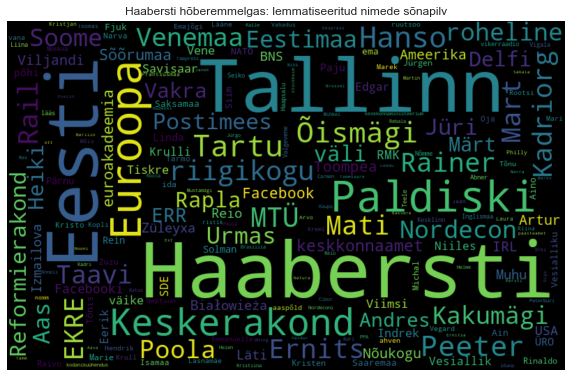

In [68]:
nimed_lemmad = []
for n in tqdm(nimed_texts):
    for sona in n:
        tekst = Text(sona).tag_layer().morph_analysis['lemma']
        nimed_lemmad.append(tekst[0][0])
        #print(tekst[0][0])

nimed_lemmad_words = ' '.join(map(str, nimed_lemmad))

wordcloud_nimed_lemmad = WordCloud(stopwords = stopsõnad_uus, width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(nimed_lemmad_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_nimed_lemmad, interpolation='bilinear')
plt.title(konflikt + ": lemmatiseeritud nimede sõnapilv")
plt.axis("off")
plt.savefig("tulemused_" + konflikt +"/" + konflikt + " joonis8_Nimed_lemmatiseeritud_sonapilv.png")
print("Nimed sõnapilves: ", len(nimed_lemmad))

In [69]:
jaotus8 =pd.DataFrame(nimed_lemmad, columns=['nimi'])
tabel8 = jaotus8.groupby(['nimi']).size().reset_index(name='esinemissagedus').sort_values(by='esinemissagedus', ascending=False)[:20]
tabel8['osakaal %']= (tabel8['esinemissagedus']/len(nimed_lemmad)*100)
tabel8_1 = tabel8.style.set_caption(konflikt + ": lemmatiseeritud nimede TOP 20")
tabel8.to_excel("tulemused_" + konflikt +"/" + konflikt + " tabel8_Nimed_lemmatiseeritud_TOP_20.xlsx")

In [70]:
tabel8_1

,nimi,esinemissagedus,osakaal %
260,Haabersti,687,10.533579
915,Tallinn,626,9.598283
180,Eesti,586,8.984974
220,Euroopa,113,1.732597
700,Paldiski,113,1.732597
427,Keskerakond,76,1.165287
922,Tartu,53,0.812634
268,Hanso,52,0.797301
1220,Õismägi,50,0.766636
715,Peeter,49,0.751303


In [1]:
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
 
%matplotlib inline  # since I'm doing this work in a Jupyter Notebook

UsageError: unrecognized arguments: # since I'm doing this work in a Jupyter Notebook


In [2]:
# reference: https://mentalitch.com/key-events-in-rock-and-roll-history/
dates = [date(1954, 7, 19), date(1959, 2, 3), date(1964, 2, 9), date(1965, 7, 25), date(1967, 6, 1), date(1969, 8, 15)]
min_date = date(np.min(dates).year - 2, np.min(dates).month, np.min(dates).day)
max_date = date(np.max(dates).year + 2, np.max(dates).month, np.max(dates).day)
 
labels = ['Elvis appears on\nthe Ed Sullivan Show', 'Buddy Holly dies', 'The Beatles appear\non the Ed Sullivan Show', 
          'Bob Dylan goes electric', 'The Beatles release\nSgt. Pepper', 'Woodstock']
# labels with associated dates
labels = ['{0:%d %b %Y}:\n{1}'.format(d, l) for l, d in zip (labels, dates)]

In [3]:
# reference: https://mentalitch.com/key-events-in-rock-and-roll-history/
dates = [date(1954, 7, 19), date(1959, 2, 3), date(1964, 2, 9), date(1965, 7, 25), date(1967, 6, 1), date(1969, 8, 15)]
min_date = date(np.min(dates).year - 2, np.min(dates).month, np.min(dates).day)
max_date = date(np.max(dates).year + 2, np.max(dates).month, np.max(dates).day)
 
labels = ['Elvis appears on\nthe Ed Sullivan Show', 'Buddy Holly dies', 'The Beatles appear\non the Ed Sullivan Show', 
          'Bob Dylan goes electric', 'The Beatles release\nSgt. Pepper', 'Woodstock']
# labels with associated dates
labels = ['{0:%d %b %Y}:\n{1}'.format(d, l) for l, d in zip (labels, dates)]

In [4]:
label_offsets = np.zeros(len(dates))
label_offsets[::2] = 0.35
label_offsets[1::2] = -0.7
for i, (l, d) in enumerate(zip(labels, dates)):
    _ = ax.text(d, label_offsets[i], l, ha='center', fontfamily='serif', fontweight='bold', color='royalblue',fontsize=12)

NameError: name 'ax' is not defined

In [ ]:
stems = np.zeros(len(dates))
stems[::2] = 0.3
stems[1::2] = -0.3   
markerline, stemline, baseline = ax.stem(dates, stems, use_line_collection=True)
_ = plt.setp(markerline, marker=',', color='darkmagenta')
_ = plt.setp(stemline, color='darkmagenta')

In [ ]:
# hide lines around chart
for spine in ["left", "top", "right", "bottom"]:
    _ = ax.spines[spine].set_visible(False)
 
# hide tick labels
_ = ax.set_xticks([])
_ = ax.set_yticks([])
 
_ = ax.set_title('Important Milestones in Rock and Roll', fontweight="bold", fontfamily='serif', fontsize=16, 
                 color='royalblue')
